In [ ]:
## Using Linear Algebra to Numerically find Wave Harmonics for N-body systems
# Felix Weber

# The general approach used in this notebook can be summarized as followed:

# We can approximate (first-order) many systems as distrete points in space connected by springs. 
# When considering only perpendicular forces, we can create a matrix that calculates the force on each individual point given the overall configuration
# Any resonant configuration of these points will have a configuration of forces proportional to the structure of points
# Therefore the eigenvectors of the force matrix will describe the resonant configurations

# Table of Contents:

# 1) 1D systems
# 2) 2D systems
# 3) Extensions
#   a. Varying Mass Density in 1D
#   b. Fixing points in 2D

In [472]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sci
from scipy.ndimage import convolve

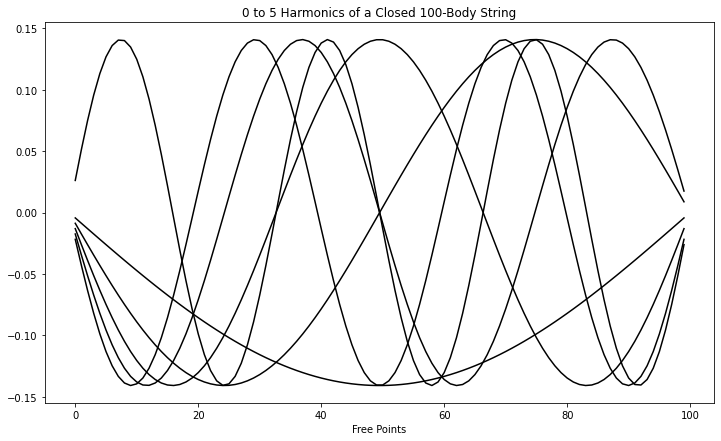

In [576]:
## 1D Wave Resonances

# Our simple set up of points in one dimension can be represented as height functions at locations {..., n-1, n, n+1, ...}:

# ... <--> y(n-1) <--> y(n) <--> y(n+1) <--> y(n+2) <--> ...

# In one dimension, the vertical force on a point at location n is proportional to y(n+1) + y(n-1) - 2 y(n)

# Boundary Conditions: 
#      For an open boundary, this becomes y(n±1) - y(n)
#      For a fixed boundary, this becomes y(n±1) - 2y(n)

# Notice, in all cases, we can generalize our equations for an N-length string:

# F_n = Sum( c(n,i) y(i), i in {0 ... N}) 

# Where c(n1,n2) defines a coefficient function --> d(|n1-n2|-1) - 2 d(n1-n2), where d is the kronecker delta
# Boundary adjustments can be included if need be

# Notice, if we want to find the foces on all points, F, the systems for F_n can be used to define a force matrix

# We can define this c(n1,n2) function robustly such that it akes our point locations and returns the appropiate coefficients 
# for the contribution of each position. 

def TensionDelta1d(n1,n2,boundary='Fixed'):
    
    s = np.shape(n1)[0]
    
    Mags = np.abs(n1-n2)
    
    TD = np.full(np.shape(Mags),0)
    
    mask = (Mags==0.)
    TD[mask] = -2
    
    mask = (Mags==1.)
    TD[mask] = 1
    
    if boundary == "Open":
        mask = (n1==0)&(Mags==0.)
        TD[mask] = -1
        
        mask = (n1==s-1)&(Mags==0.)
        TD[mask] = -1
    
    return TD

# We can then define a function that generates the NxN force matrix M: y ---> F, 
# where y is the position vector of all points, and F is the force vector, s.t. F_i is the vertical force on y_i

def TensionMatrix1d(size, boundary='Fixed'):
    
    Indices = np.linspace(0,size-1,size,dtype=int)

    IndexMesh = np.meshgrid(Indices,Indices)
    
    Matrix = TensionDelta1d(IndexMesh[0],IndexMesh[1], boundary=boundary)
    
    return Matrix

# Now Let us choose a length of our 1d chain:

size=100
boundary = "Closed"

# Using our defined functions, we can find the force matrix on all points:

Mat = TensionMatrix1d(size, boundary=boundary)

# Then find the eigenvectors of the matrix

eigvals, eigvecs = np.linalg.eig(Mat)

# Then we can sort by the eigenvalues 
# Note, the eigenvalues are proportional to the resonant frequency => lowest eigenvalue is the fundamental resonance

eigvalssort = eigvals[np.flip(np.argsort(eigvals))]
eigvecs = eigvecs.T[np.flip(np.argsort(eigvals))]

# Now we can plot the the first couple of harmonics!

Start_Harm = 0
Stop_Harm = 6

plt.figure(figsize=(12,7))
plt.title(str(Start_Harm) + " to " + str(Stop_Harm-1) + " Harmonics of a " + boundary + " " + str(size) +"-Body String")
for i,sol in enumerate(eigvecs[Start_Harm:Stop_Harm]):
    plt.plot(sol*np.sign(eigvalssort[i]), color='k')
plt.xlabel("Free Points")
plt.show()

In [551]:
## 2D Wave Resonances

# In the case of a 2D system we have a network of points on springs

#  |        |           |            |        |
# ... - y(x-1,y+1) - y(x,y+1) - y(x+1,y+1) - ...
#  |        |           |            |        |
# ... -  y(x-1,y)  -  y(x,y)  -  y(x+1,y)  - ...
#  |        |           |            |        |
# ... - y(x-1,y-1) - y(x,y-1) - y(x+1,y-1) - ...
#  |        |           |            |        |

# The force on point y(x,y) will be proportional to y(x,y+1) + y(x+1,y) + y(x,y-1) + y(x-1,y) - 4 y(x,y)

# Boundary Conditions:
#     For an open bounadry, the coefficient on y(x,y) is equal to number of springs
#     For a closed boundary, we ignore the non-existant terms, and y(x,y) still has a coefficient of -4

# For an NxM grid, we will have NM points. We can now flatten our 2D array while still retaining our original coordinates:

# => r = { (0,0), ... , (0,M), (1,0), ..., (1,M), ......, (N,0), ..., (N,M) } 

# Like in the 1D case, we can now define a new coefficient function that accounts for the 2D connections:

# c(r1,r2) = d(|r1-r2|-1) - 4 d(|r1-r2|)

# Note, r is an array of 2d vector indeces, unlike in the 1d case.
# We now have a linear expression for F_i (indexed the same as r_i):

# F_i = Sum( c(r_i,r2) * y(r2), for r2 in r)

# Where y(r_i) is the value of y at coordinate r_i.
# Like in the 1D case, we can create another Force matrix, this will be a (NM)x(NM) size matrix.

# Likewise, the eigenvectors of this matrix will give us the resonant solutions for our system, which can then be plotted visually upon reordering
# along the coordinates given in r.

# In this example, we are going to assume a NxN grid of points:

size = 8**2 # value for N

# Then we generate our grid of coordinates:

Coords = np.meshgrid(np.linspace(0,size-1,size,dtype=int),np.linspace(0,size-1,size,dtype=int))

# Now we can define some helper functions to generate our force matrix:

def Magnitude(vector):
    return np.sqrt(np.sum(vector**2,axis=-1))

def TensionDelta(vec1,vec2):
    
    Mags = Magnitude(vec1-vec2)
    
    TD = np.full(np.shape(Mags),0)
    
    mask = (Mags==0.)
    TD[mask] = -4
    
    mask = (Mags==1.)
    TD[mask] = 1
    
    return TD

def TensionMatrix(Coords):
    
    Flat_Coords = np.array((Coords[0].flatten(),Coords[1].flatten())).T
    
    Indices = np.linspace(0,len(Flat_Coords)-1,len(Flat_Coords),dtype=int)

    IndexMesh = np.meshgrid(Indices,Indices)
    
    Matrix = TensionDelta(Flat_Coords[IndexMesh[0]],Flat_Coords[IndexMesh[1]])
    
    return Matrix

# Now we can generate the force matrix and find the eigenvectors:

Mat = TensionMatrix(Coords)
eigvals, eigvecs = np.linalg.eig(Mat)

# Now we can sort by eigenvalues again to extract the fundamental harmonics

eigvalssort = eigvals[np.flip(np.argsort(eigvals))]
eigvecssort = eigvecs.T[np.flip(np.argsort(eigvals))]

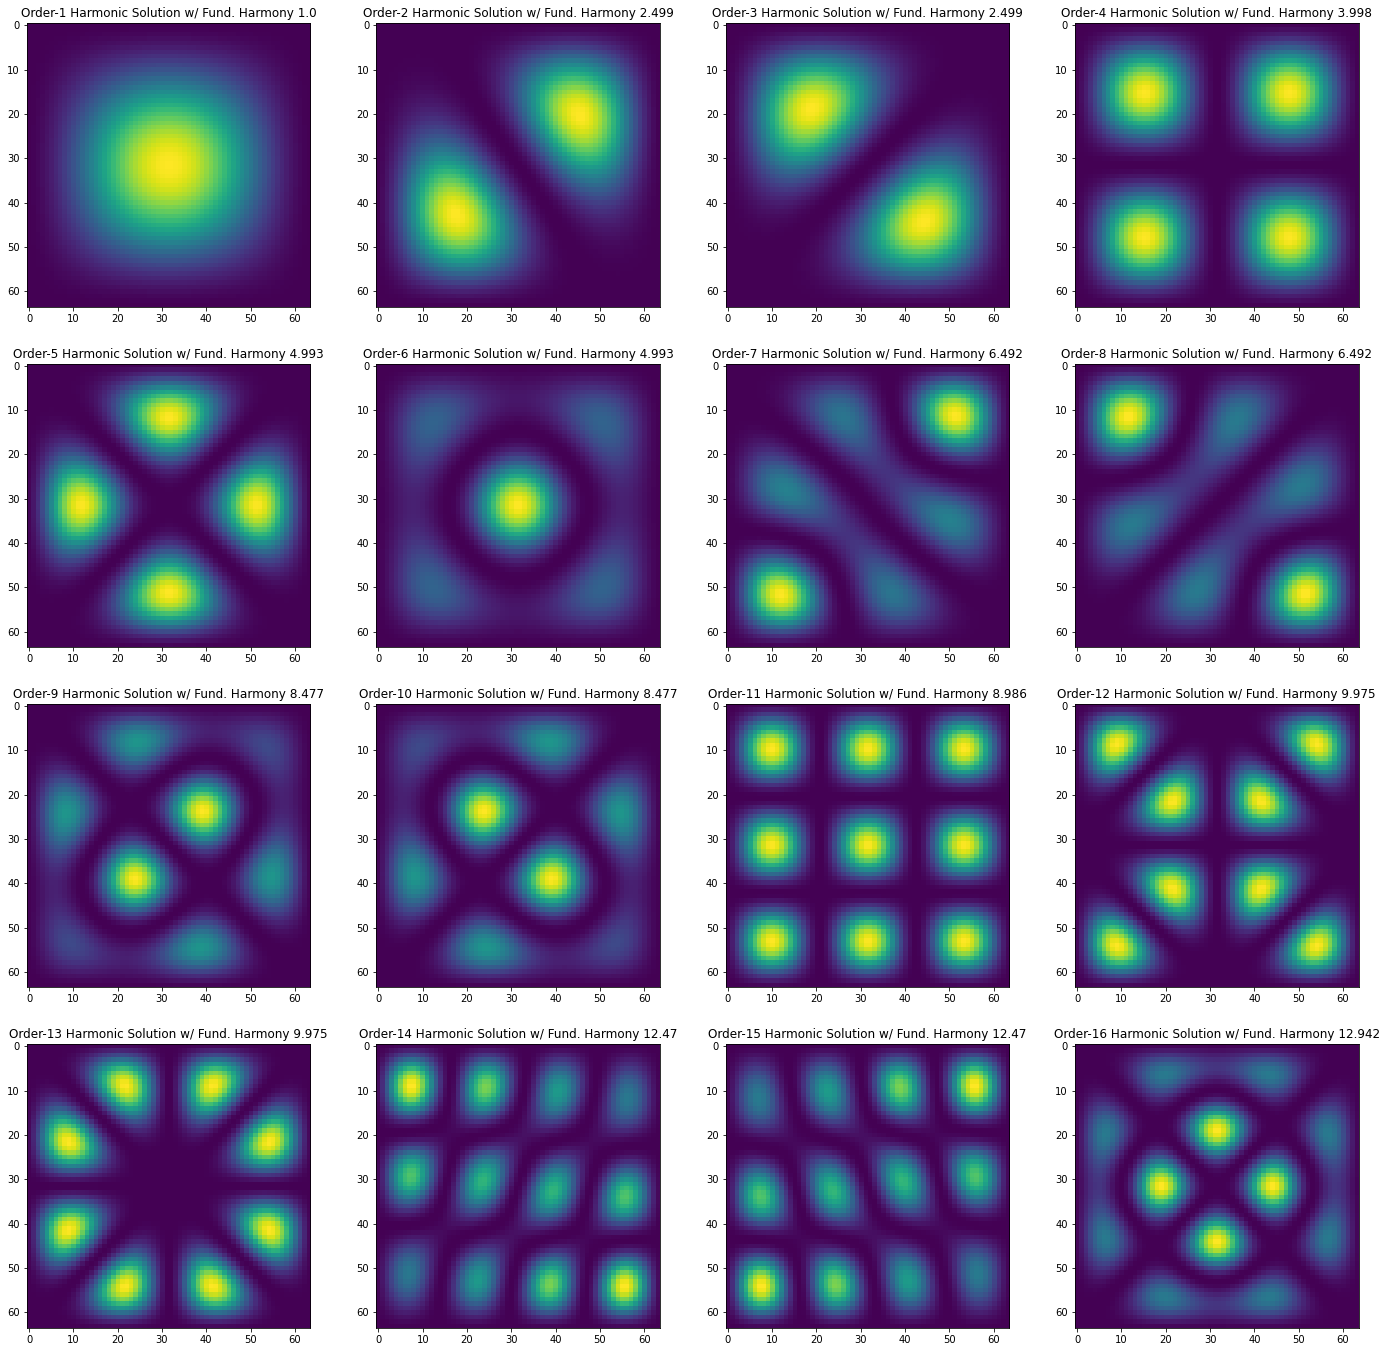

In [552]:
# We can now plot our first 16 resonant solutions

harms=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]

fig, axs = plt.subplots(4,4, figsize=(24,24))

for i,harm in enumerate(harms):
    x = i // 4
    y = i % 4
    axs[x,y].set_title("Order-"+str(harm+1)+" Harmonic Solution w/ Fund. Harmony " + str(round(eigvalssort[harm]/eigvalssort[0],3)))
    axs[x,y].imshow(np.reshape(eigvecssort[harm]**2,np.shape(Coords[0])),interpolation='none')
    
plt.show()

In [629]:
## Extensions: Fixing Points in 2D

# In this case, we only need to mask certain points from our matrix

def Fixing(Coords):
    
    x = Coords[0]/np.max(Coords[0])
    y = Coords[1]/np.max(Coords[1])
    
    mask = (((x-0.5)**2 + (y-0.5)**2)<0.5**2)&(~(np.abs(x-0.5)>.3)) # Circiular Mask -- This can be used for cylindrical harmonics
    #mask = (((x-0.5)**2 + (y-0.2)**2)<0.2**2)+(((x-0.5)**2 + (y-0.65)**2)<0.35**2)
    
    return mask
    
# Now we can modify our original functions, alongside adding an option for changing the boundary conditions:

def TensionDelta(vec1,vec2, boundary='Fixed'):
    
    Mags = Magnitude(vec1-vec2)
    
    TD = np.full(np.shape(Mags),0)
    
    OpenMat = [[0,-1,0],[-1,0,-1],[0,-1,0]]
    
    mask = (Mags==0.)
    TD[mask] = -4
    
    mask = (Mags==1.)
    TD[mask] = 1
    
    if boundary=='Open':
        InOut = Fixing(Coords).astype(int)
        cnn = convolve(InOut,np.array([[0,-1,0],[-1,0,-1],[0,-1,0]]))*InOut
        mask = (Mags==0.)
        TD[mask] = cnn.flatten()
    
    return TD

def TensionMatrix(Coords,boundary):
    
    Flat_Coords = np.array((Coords[0].flatten(),Coords[1].flatten())).T
    
    Indices = np.linspace(0,len(Flat_Coords)-1,len(Flat_Coords),dtype=int)

    IndexMesh = np.meshgrid(Indices,Indices)
    
    Matrix = TensionDelta(Flat_Coords[IndexMesh[0]],Flat_Coords[IndexMesh[1]],boundary=boundary)
    
    mask = Fixing(Coords).flatten()
    
    return Matrix[mask][:,mask]

# Now we can calculate

size = 8**2 # value for N

# Then we generate our grid of coordinates:

Coords = np.meshgrid(np.linspace(0,size-1,size,dtype=int),np.linspace(0,size-1,size,dtype=int))

# Now we can generate the force matrix and find the eigenvectors:

Mat = TensionMatrix(Coords,boundary='Closed')
eigvals, eigvecs = np.linalg.eig(Mat)

# Now we can sort by eigenvalues again to extract the fundamental harmonics

eigvalssort = eigvals[np.flip(np.argsort(eigvals))]
eigvecssort = eigvecs.T[np.flip(np.argsort(eigvals))]

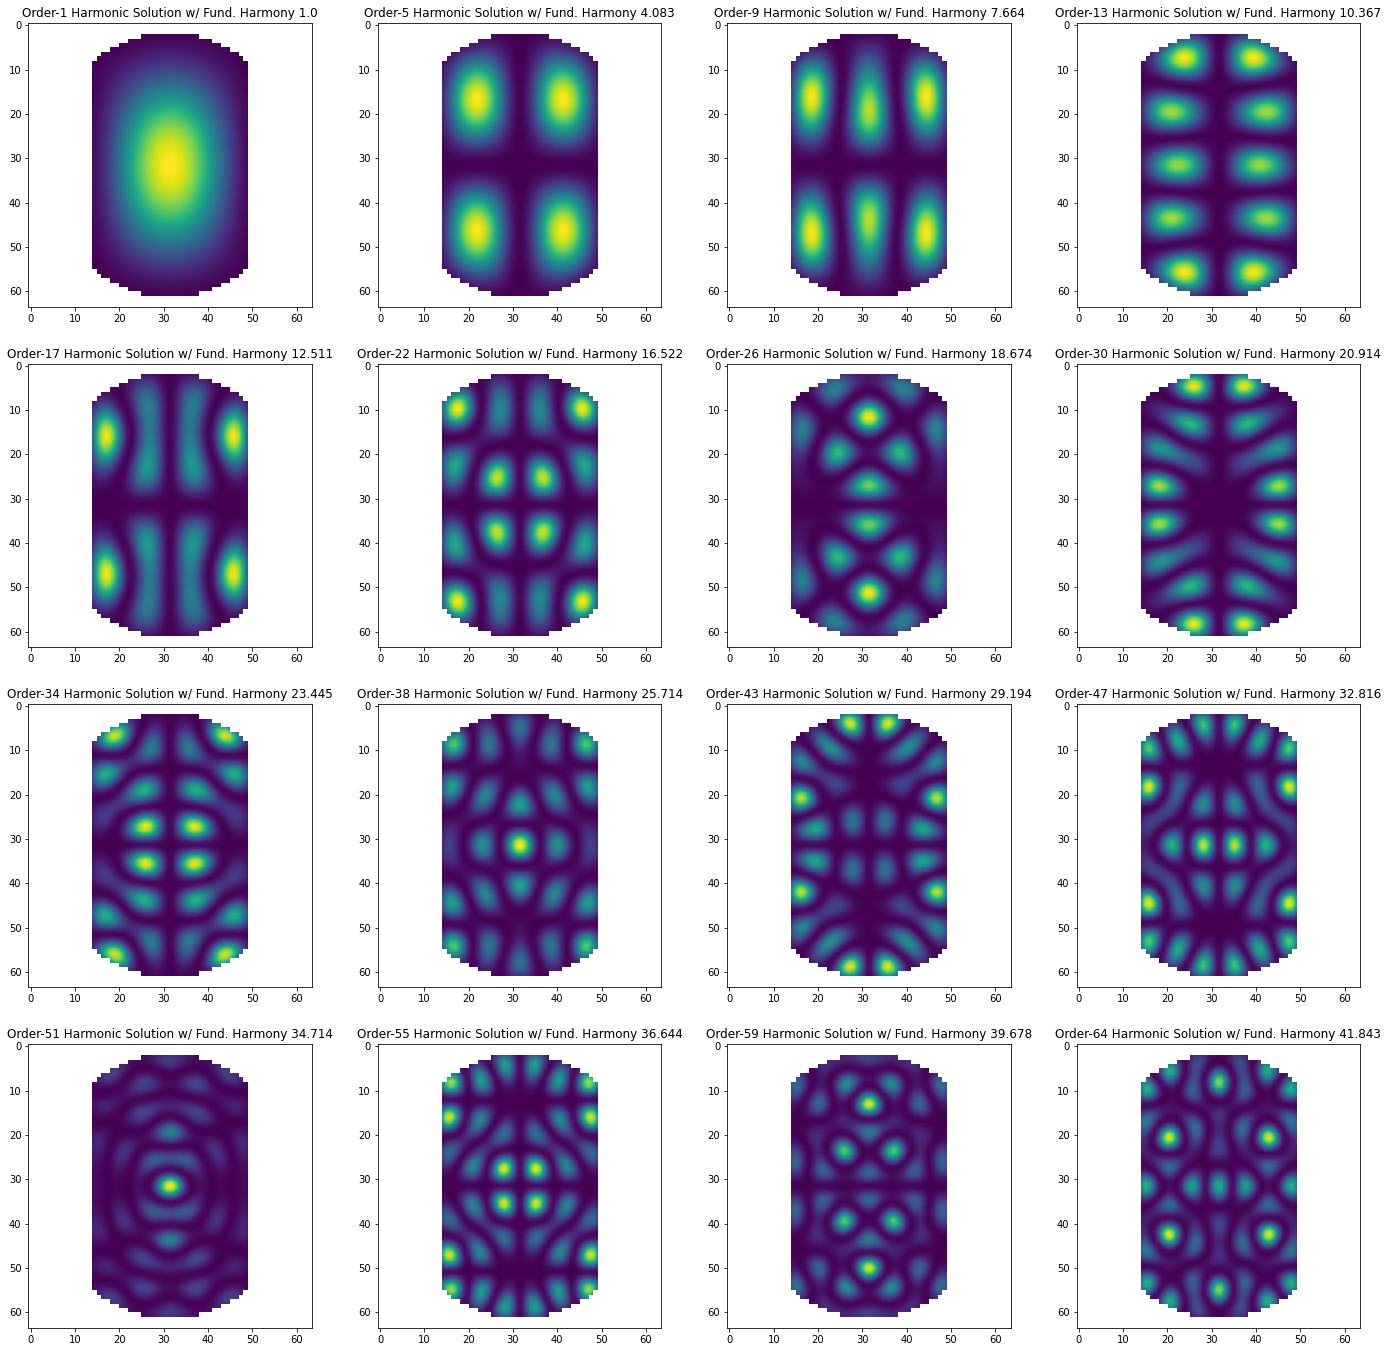

In [631]:
# We can now plot 16 resonant solutions

harms=np.linspace(0*16,3*16+15,16,dtype=int)#[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]

fig, axs = plt.subplots(4,4, figsize=(24,24))

vmin = np.min(eigvecssort)
vmax = np.max(eigvecssort)

for i,harm in enumerate(harms):
    x = i // 4
    y = i % 4
    axs[x,y].set_title("Order-"+str(harm+1)+" Harmonic Solution w/ Fund. Harmony " + str(round(np.abs(eigvalssort[harm]/eigvalssort[0]),3)))
    sol = np.zeros(np.shape(Coords[0]))
    sol[Fixing(Coords)] = np.real(eigvecssort[harm])
    sol[~Fixing(Coords)] = np.nan
    axs[x,y].imshow(np.reshape(sol**2,np.shape(Coords[0])),interpolation='gaussian')  
    
plt.show()

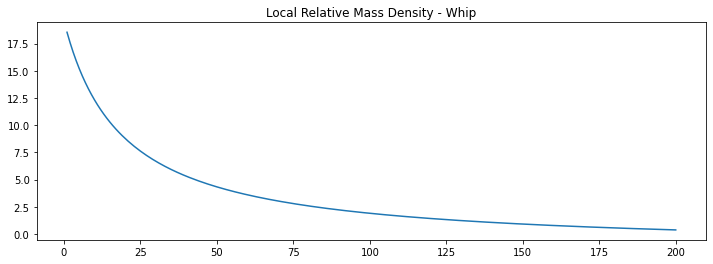

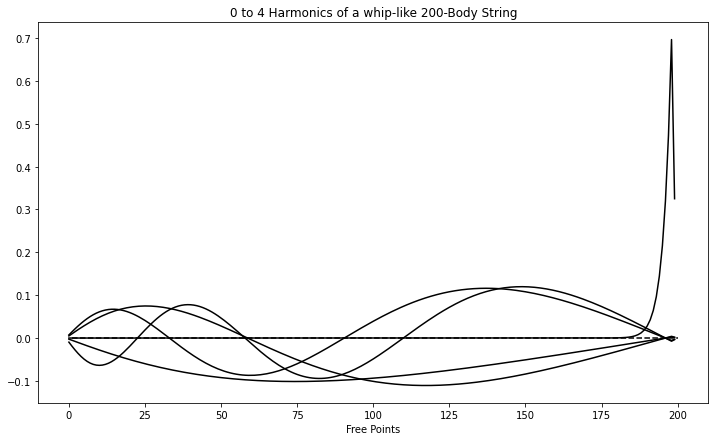

In [523]:
## Extensions - Changing density on a string

# We can modify our original functions to account for anisotropic densities in our string. This is simply done by dividing F_n by the relative mass m_n

# An implementation of this is shown below:

# First we define a mass function:

def MassFunc(xs,Start,Stop):
    
    z = (xs-Start)/(Stop-Start)
    mass = 2/(z+.1)-1.45        # This simulates the distribution of a whip
    
    return mass

# We can display the masses now:

size = 200

xs = np.linspace(1,size,size)
masses = MassFunc(xs,1,size)

plt.figure(figsize=(12,4))
plt.title("Local Relative Mass Density - Whip")
plt.plot(xs,MassFunc(xs,1,size))
plt.show()
    
    
# We can now modify our original functions:    
    
def TensionDelta1d_mass(n1,n2,masses,boundary='Fixed'):
    
    s = np.shape(n1)[0]
    
    Mags = np.abs(n1-n2)
    
    TD = np.full(np.shape(Mags),0)
    
    mask = (Mags==0.)
    TD[mask] = -2
    
    mask = (Mags==1.)
    TD[mask] = 1
    
    if boundary == "Open":
        mask = (n1==0)&(Mags==0.)
        TD[mask] = -1
        
        mask = (n1==s-1)&(Mags==0.)
        TD[mask] = -1
    
    return (TD.T/(masses)).T

def TensionMatrix1d_mass(size, masses, boundary='Fixed'):
    
    Indices = np.linspace(1,size,size,dtype=int)

    IndexMesh = np.meshgrid(Indices,Indices)
    
    Matrix = TensionDelta1d_mass(IndexMesh[0],IndexMesh[1], masses, boundary=boundary)
    
    return Matrix

# Using our new functions, we can find the force matrix on all points:

Mat = TensionMatrix1d_mass(size, MassFunc(xs,1,size), boundary='Open')

# Then find the eigenvectors of the matrix

eigvals, eigvecs = np.linalg.eig(Mat)

# Then we can sort by the eigenvalues 
# Note, the eigenvalues are proportional to the resonant frequency => lowest eigenvalue is the fundamental resonance

eigvalssort = eigvals[np.flip(np.argsort(eigvals))]
eigvecs = eigvecs.T[np.flip(np.argsort(eigvals))]

# Now we can plot the the first couple of harmonics! Notice, the first harmonic demonstrates a whipping motion showing how a whip "works"

Start_Harm = 0
Stop_Harm = 5
 
plt.figure(figsize=(12,7))
plt.title(str(Start_Harm) + " to " + str(Stop_Harm-1) + " Harmonics of a whip-like " + str(size) +"-Body String")
for i,sol in enumerate(eigvecs[Start_Harm:Stop_Harm]):
    plt.plot(sol*np.sign(eigvalssort[i]), color='k')
plt.xlabel("Free Points")
plt.hlines(0,xs[0],xs[-1],color='k',ls='--')
plt.show()